# Minimax Probability Machine

## Generate datasets

In [1]:
using Plots
using LinearAlgebra
using Statistics
using Distributions
using JuMP, AmplNLWriter

include("../svm/utils.jl")

function get_clouds()
    N = 1000
    c1 = [3; -3]
    c2 = [0; 0]
    # c1 = np.array([0, 3])
    # c2 = np.array([0, 0])
    X1 = randn(N, 2) + repeat(c1',N)
    X2 = randn(N, 2) + repeat(c2',N)
    X = vcat(X1, X2)
    Y = vcat(-1 .* ones(N), 1 .* ones(N))
    return X, Y
end

function get_multivariate_normal()
    N = 500
    muX = [2; 5]
    sigX = [4 4; 4 8] 
    sigX = (sigX ./ norm(sigX)) .* 2
    X1 = rand(MvNormal(muX, sigX),N)'

    muY = [12; 4]
    sigY = [8 -4; -4 3]
    sigY = sigY ./ norm(sigY)
    sigY = sigY .* 3 
    X2 = rand(MvNormal(muY, sigY),N)'
    X = vcat(X1, X2)
    Y = vcat(-1 .* ones(N), 1 .* ones(N))
    return X,Y
end

get_multivariate_normal (generic function with 1 method)

In [2]:
function plot_data(data)
    X, y = data
    if y == nothing
        global plt = scatter(X[:,1], X[:,2])
    else
        let i = 1
            for label in unique(y)
                if i == 1
                    global plt = scatter(X[y.==label,1], X[y.==label,2])    
                else
                    plt = scatter!(X[y.==label,1], X[y.==label,2])
                end
                i += 1
            end
        end
    end
    display(plt);
end

plot_data (generic function with 1 method)

In [3]:
n_samples = 1500
#noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = make_moons(n_samples=n_samples, noise=0.05)
blobs = make_blobs(n_samples=n_samples, random_state=999)
no_structure = (rand(n_samples, 2), nothing)

# Anisotropicly distributed data
random_state = 1
X, y = make_blobs(n_samples=n_samples)#, random_state=random_state)
transformation = [0.6 -0.6; -0.4 0.8]
X_aniso = X*transformation
aniso = (X_aniso, y)

# blobs with varied variances
varied = make_blobs(n_samples=n_samples,cluster_std=[1.0, 2.5, 0.5],random_state=random_state);

In [4]:
#plot_data(aniso)

## Plot dataset

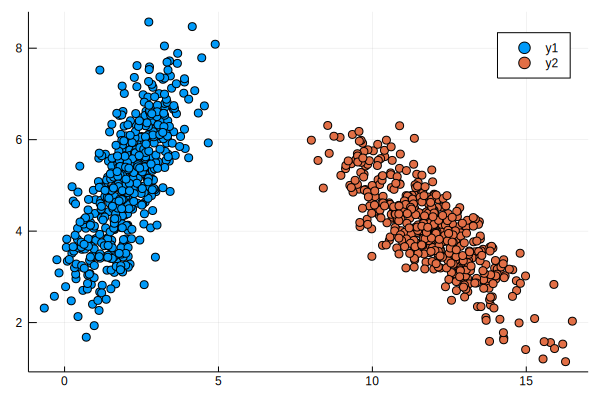

In [5]:
#X_original, Y_original = get_clouds()
X_original, Y_original = get_multivariate_normal()

plot_data((X_original, Y_original));

## Define optimization models

### Minimax Probability Machine

The optimization problem that the MPM solves is the following SOCP:

%% latex
\begin{equation*}
\begin{aligned}
\underset{\textbf{a}}{\text{min}}
&&& \sqrt{\textbf{a}^T \Sigma_x \textbf{a}} + \sqrt{\textbf{a}^T \Sigma_y \textbf{a}} \\
\text{s.t.}
&&&  \textbf{a}^T (\overline{\textbf{x}} - \overline{\textbf{y}}) = 1 \\
\end{aligned}
\end{equation*}

Once the optimal value for $\textbf{a}$ has been found, $b$ (the separating line intercept) can computed as follows:

\begin{equation}
b = \textbf{a}^T \overline{\textbf{x}} - \dfrac{ \sqrt{\textbf{a}^T \Sigma_x \textbf{a}} }{ \sqrt{\textbf{a}^T \Sigma_x \textbf{a}} + \sqrt{\textbf{a}^T \Sigma_y \textbf{a}} }
\end{equation}

In [6]:

function solve_mpm(X,Y)
    # Minimax Probability Machine
    println(size(X))

    # calculate mean of data
    mean_x = dropdims(mean(X, dims=1), dims=1)
    mean_y = dropdims(mean(Y, dims=1), dims=1)

    # calculate covariance matrix of data
    sigmaX = cov(X, dims=1)
    sigmaY = cov(Y, dims=1)

    # number of classes
    n = 2

    # Optimization model
    model = Model(solver=AmplNLSolver("couenne", [""]))

    # Variables
    @variable(model, a[1:n])
    #@variable(model, ξ >= 1e-7)

    # Objective
    @NLobjective(model, Min, sqrt( sum(a[i]*sigmaX[i,j]*a[j] for i=1:n, j=1:n)) +
                             sqrt( sum(a[i]*sigmaY[i,j]*a[j] for i=1:n, j=1:n)));

    # Constraints
    @constraint(model, con, sum(a[i] * (mean_x[i] - mean_y[i]) for i=1:n) == 1);
    #@constraint(model, con, sum(a[i] * (mean_y[i] - mean_x[i]) for i=1:n) == 1);

    # Set initial value to 1 to prevent the solver from trying to calculate the derivative at sqrt(0)
    setvalue(a, [1;1])

    println()
    status = solve(model)
    solvetime = getsolvetime(model)
    obj_value = getobjectivevalue(model);
    println("Solve time: ", solvetime)
    println("Objective=", obj_value);


    a = getvalue(a)
    println("a=$a")

    # calculate b
    b = a'*mean_x - sqrt(a'*sigmaX*a) / (sqrt(a'*sigmaX*a) + sqrt(a'*sigmaY*a))
    return a, b
end


solve_mpm (generic function with 1 method)

### Linear SVM

The optimization problem that the Linear SVM solves is the following QP:

%% latex
\begin{equation*}
\begin{aligned}
\underset{\textbf{w},b,\xi}{\text{min}}
&&& \dfrac{1}{2} \| \textbf{w}\|^2 + C \sum_{i=1}^{N} \xi^{(i)}  \\
\text{s.t.}
&&&  y^{(i)} (\textbf{w}^T \textbf{x}^{(i)} + b ) \geq 1 - \xi^{(i)} \\
\end{aligned}
\end{equation*}

In [7]:

function solve_svm(x,y,C)
    num_samples, N_dims = size(x)

    # Optimization model
    model = Model(solver=AmplNLSolver("couenne", [""]));

    # Variables
    @variable(model, w[1:N_dims])
    @variable(model, b)
    @variable(model, ξ[1:num_samples] >= 0.0)

    # Objective
    # ξ
    @NLobjective(model, Min, 0.5*sum(w[k]^2 for k=1:N_dims) + C*sum(ξ[i] for i=1:num_samples))

    # Constraints
    @constraint(model, con[i=1:num_samples], y[i]*(w'*x[i,:] + b) >= 1 - ξ[i])

    # Solve
    println()
    status = solve(model)
    solvetime = getsolvetime(model)
    obj_value = getobjectivevalue(model);
    println("Solve time: ", solvetime)
    println("Objective=", obj_value);

    # Recover variable values
    w_opt = getvalue(w)
    b_opt = getvalue(b)

    return w_opt, b_opt
end

solve_svm (generic function with 1 method)

## Solve optimization problem

In [8]:
X = X_original[Y_original.==-1,:]
Y = X_original[Y_original.==1,:]

a,b = solve_mpm(X,Y)

(500, 2)

Couenne 0.5.6 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions: http://www.coin-or.org/Couenne
couenne: 
ANALYSIS TEST: Couenne: new cutoff value 2.2013161291e+001 (0.015 seconds)
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 0.23184693        7 0
Couenne: new cutoff value 2.3184692892e-001 (0.015 seconds)
Loaded instance "C:\Users\Breno\.julia\packages\AmplNLWriter\V1gW5\.solverdata\jl_48AD.tmp.nl"
Constraints:            1
Variables:              2 (0 integer)
Auxiliaries:            8 (0 integer)

Coin0506I Presolve 26 (-2) rows, 9 (-1) columns and 57 (-8) elements
Clp0006I 0  Obj 0 Primal inf 0.20691193 (5)
Clp0006I 8  Obj 0.1136006
Clp0000I Optimal - objective value 0.1136006
Clp0032I Optimal objective 0.1136006017 - 8 iterations time 0.002, Presolve 0.00
Clp0000I Optimal - objective value 0.1136006
Cbc0012I Integer

([-0.0981039, 0.0284068], -0.35575487132758277)

In [9]:
C = 1.0
w_svm, b_svm = solve_svm(X_original, Y_original, C)


Couenne 0.5.6 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions: http://www.coin-or.org/Couenne
couenne: 
ANALYSIS TEST: Reformulating problem: Couenne: new cutoff value 1.0000000000e+003 (0.156 seconds)
0.1 seconds
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 0.1809244       21 0.476
Couenne: new cutoff value 1.8093439007e-001 (0.632 seconds)
Loaded instance "C:\Users\Breno\.julia\packages\AmplNLWriter\V1gW5\.solverdata\jl_6166.tmp.nl"
Constraints:         1000
Variables:           1003 (0 integer)
Auxiliaries:            4 (0 integer)

Coin0506I Presolve 1010 (-2) rows, 1006 (-1) columns and 5021 (-4) elements
Clp0006I 0  Obj 0 Primal inf 404.67401 (505)
Clp0006I 16  Obj 0.17896624
Clp0000I Optimal - objective value 0.17896624
Clp0032I Optimal objective 0.1789662439 - 16 iterations time 0.012
Clp0000I Optimal - objective value 

([0.598285, -0.062644], -3.421564869901692)

## Plot results

### Obtain separating lines

In [10]:
# Retrieve equation for the optimal separation line
min_x = minimum(X_original[:,1])
max_x = maximum(X_original[:,1])
min_y = minimum(X_original[:,2])
max_y = maximum(X_original[:,2])
xx = range(min_x-abs(min_x)*0.1,stop=max_x+abs(max_x)*0.1,length=1000)

if abs(a[2]) > 1e-5
    y_line = - (a[1]/a[2]).*xx .+ (b/a[2])
end

a_svm = - w_svm[1] / w_svm[2]
y_line_svm = a_svm.*xx .+ (-b_svm / w_svm[2])

-61.549015388303914:0.1804250607902793:118.69562034118512

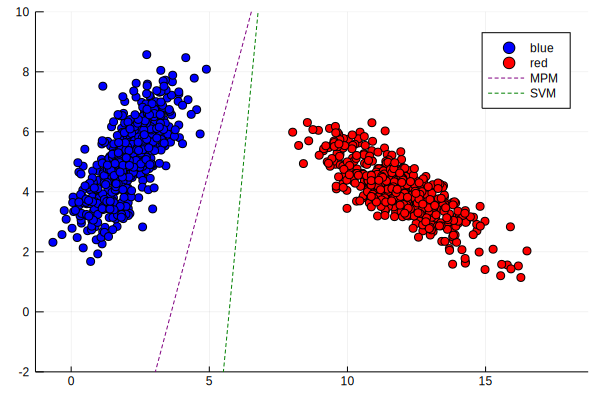

In [11]:
plt = scatter(X[:,1], X[:,2], color=:blue, leg=false, label="blue")
plt = scatter!(Y[:,1], Y[:,2], color=:red, leg=false, label="red")
if abs(a[2]) > 1e-5
    plot!(xx, y_line, linestyle=:dash, color=:purple, leg=true, ylim=(-2, 10), label="MPM")
else
    println("vertical line")
    vline!([a[1]], linestyle=:dash, color=:gray)
end

plot!(xx, y_line_svm, linestyle=:dash, color=:green, leg=true, ylim=(-2, 10), label="SVM")

display(plt)

In [12]:
savefig(plt, "mpm_vs_svm.pdf");